<a href="https://colab.research.google.com/github/nandikonda-vishal21/DEEP-LEARNING/blob/main/vehicle_sound_classification_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing required libraries**

**Librosa** is an open-source library in python that is used for audio processing and analysis.

**Scipy** is a well-known python library, it is used for signal processing, image processing, linear algebra etc.


In [1]:
#Audio Processing Libraries
import librosa
from scipy import signal
#For Playing Audio
import IPython.display as ipd
#Array Processing
import numpy as np
#Data Visualization
import matplotlib.pyplot as plt

In [2]:
path='/content/emergency.wav'
emergency,sample_rate = librosa.load(path, sr = 16000)
path='/content/non emergency.wav'
non_emergency,sample_rate= librosa.load(path, sr =16000)

This parameter sr is the **sampling rate**, which is the number of samples per second. We have used a sampling rate of **16000** to read these two audio clips and the duration of these audio clips is around **23 minutes and 27 minutes**. Basically, we are preparing a data set of audio chunks to train a deep learning model to perform audio Classification.

In [4]:
def prepare_data(samples, num_of_samples=32000, num_of_common=16000):
  data=[]
  for offset in range(0, len(samples), num_of_common):
   start = offset
   end   = offset + num_of_samples
   chunk = samples[start:end]
   if(len(chunk)==32000):
     data.append(chunk)
  return data

In [5]:
emergency = prepare_data(emergency)
non_emergency = prepare_data(non_emergency)

In [6]:
print("No. of Chunks of Emergency and Non Emergency:",len(emergency),len(non_emergency))

No. of Chunks of Emergency and Non Emergency: 1374 1628


**Visualizing the Audio Data**

Text(0, 0.5, 'Amplitude')

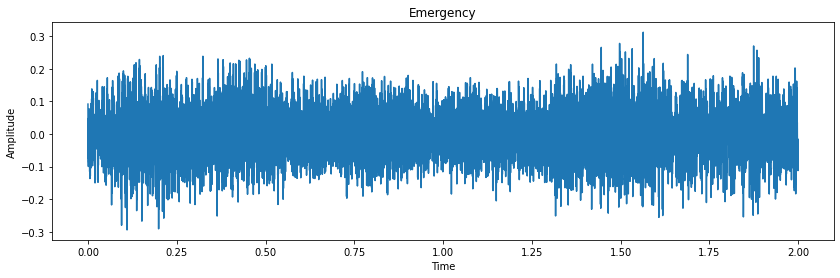

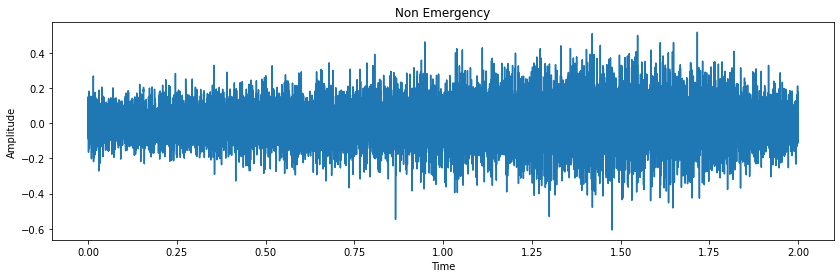

In [7]:
plt.figure(figsize=(14,4))
plt.plot(np.linspace(0, 2, num=32000),emergency[103])
plt.title('Emergency')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.figure(figsize=(14,4))
plt.plot(np.linspace(0, 2, num=32000),non_emergency[102])
plt.title('Non Emergency')
plt.xlabel('Time')
plt.ylabel('Amplitude')

The first plot is for emergency vehicles and the second plot is for non-emergency vehicles. Now from these audio chunks, we will prepare the training and validation data. We will treat the emergency vehicle audio chunks as one class and the non-emergency vehicle audio chunks as the other class. So it will become a binary classification problem.

The first step here is to combine them into two categories of audio chunks and assign labels of these chunks zero for emergency vehicle chunks and one for the non-emergency vehicle chunks.

In [8]:
audio = np.concatenate([emergency,non_emergency])
labels1 = np.zeros(len(emergency))
labels2 = np.ones(len(non_emergency))
labels = np.concatenate([labels1,labels2])
print(audio.shape)

(3002, 32000)


The shape of the combined data is 3002 chunks, with 32000 dimensions.

Now, we will split the data into training and validation sets.

In [9]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(audio),np.array(labels),
                                             stratify=labels,test_size = 0.1,
                                                   random_state=777,shuffle=True)

These two arrays, x_tr, and x_val are two-dimensional arrays. The first dimension is the number of chunks and the second dimension is the number of samples which is 32000.

As we know, a sequence model has three dimensions, that are the number of examples or chunks, the number of time steps, and the third dimension being the length of the features. This third dimension is not present in our array as of now. So in this code cell, we are reshaping the two-dimensional arrays into three-dimensional arrays and in the third dimension, we have set it to one.

In [10]:
x_tr_features  = x_tr.reshape(len(x_tr),-1,1)
x_val_features = x_val.reshape(len(x_val),-1,1)
print("Reshaped Array Size",x_tr_features.shape)

Reshaped Array Size (2701, 32000, 1)


**Model Building using CNN**

Note that we are using one-dimensional convolutional layers or Conv1D because we want the filters to move across one-dimensional only. The number of filters in the first Conv1D layer is 8, and the height of the filters is 13. the number of filters in the second Conv1D layer is 16 and the height of the filter is 11. then comes down the GLobal max-pool layer, which will convert the two-dimensional array output of the previous layer. The one-dimensional output will be fed to one dense layer as you can see here. Finally, the final layer makes the prediction.

This entire architecture is contained in a function so that you can use this architecture multiple times without having to define it again and again, and this function returns two items, the model itself and the saved model weights.

In [11]:
from keras.layers import *
from keras.models import *
from keras.callbacks import *
from keras import backend as K

def cnn(x_tr):
   K.clear_session()
   inputs = Input(shape=(x_tr.shape[1],x_tr.shape[2]))
  #First Conv1D layer
   conv = Conv1D(8, 13, padding='same', activation='relu')(inputs)
   conv = Dropout(0.3)(conv)
   conv = MaxPooling1D(2)(conv)
  #Second Conv1D layer
   conv = Conv1D(16, 11, padding='same', activation='relu')(conv)
   conv = Dropout(0.3)(conv)
   conv = MaxPooling1D(2)(conv)
  #MaxPooling 1D
   conv = GlobalMaxPool1D()(conv)
  #Dense Layer 
   conv = Dense(16, activation='relu')(conv)
   outputs = Dense(1,activation='sigmoid')(conv)
   model = Model(inputs, outputs)
   model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
   model_checkpoint = ModelCheckpoint('best_model.hdf5', monitor='val_acc',
                                 verbose=1, save_best_only=True, mode='max')
   return model, model_checkpoint
model, model_checkpoint = cnn(x_tr_features)

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32000, 1)]        0         
                                                                 
 conv1d (Conv1D)             (None, 32000, 8)          112       
                                                                 
 dropout (Dropout)           (None, 32000, 8)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 16000, 8)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 16000, 16)         1424      
                                                                 
 dropout_1 (Dropout)         (None, 16000, 16)         0         
                                                             

In [13]:
history=model.fit(x_tr_features, y_tr ,epochs=10,       callbacks=[model_checkpoint], 
batch_size=32, validation_data=(x_val_features,y_val))

Epoch 1/10
85/85 [==============================] - ETA: 0s - loss: 0.6138 - acc: 0.7186
Epoch 00001: val_acc improved from -inf to 0.80731, saving model to best_model.hdf5
85/85 [==============================] - 75s 865ms/step - loss: 0.6138 - acc: 0.7186 - val_loss: 0.5852 - val_acc: 0.8073
Epoch 2/10
85/85 [==============================] - ETA: 0s - loss: 0.4613 - acc: 0.8275
Epoch 00002: val_acc improved from 0.80731 to 0.85050, saving model to best_model.hdf5
85/85 [==============================] - 73s 858ms/step - loss: 0.4613 - acc: 0.8275 - val_loss: 0.4786 - val_acc: 0.8505
Epoch 3/10
85/85 [==============================] - ETA: 0s - loss: 0.3638 - acc: 0.8597
Epoch 00003: val_acc improved from 0.85050 to 0.85382, saving model to best_model.hdf5
85/85 [==============================] - 72s 848ms/step - loss: 0.3638 - acc: 0.8597 - val_loss: 0.4132 - val_acc: 0.8538
Epoch 4/10
85/85 [==============================] - ETA: 0s - loss: 0.3349 - acc: 0.8704
Epoch 00004: val_acc

In [14]:
model.load_weights('best_model.hdf5')

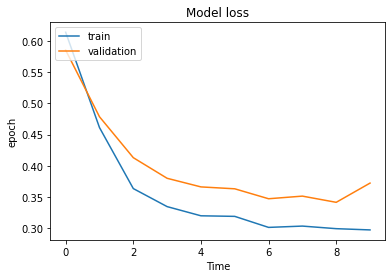

In [18]:
#summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Time')
plt.ylabel('epoch')
plt.legend(['train','validation'],loc = 'upper left')
plt.show()

In [19]:
_, acc = model.evaluate(x_val_features,y_val)
print("Validation Accuracy:",acc)

10/10 [==============================] - 2s 188ms/step - loss: 0.3475 - acc: 0.8870
Validation Accuracy: 0.8870431780815125


In [20]:
ind=35
test_audio = x_val[ind]
ipd.Audio(test_audio,rate=16000)
feature = x_val_features[ind]
prob = model.predict(feature.reshape(1,-1,1))
if (prob[0][0] < 0.5 ):
 pred='emergency'
else:
 pred='non emergency'
print("Prediction:",pred)

Prediction: emergency


**Model Building using LSTM**

Let’s once again, look at the shape of the input sequences. ere, the number of samples is 32000 and if you are using an LSTM layer, it means that there will be 32000 steps to deal with for every channel. In that case, the model training would be extremely slow and the vanishing gradient might also come into play.

So to overcome this problem, we will use a simple hack, so as you can see here in the shape, instead of keeping the third dimensions as one, we can set it to a higher number, such as 160, so that will, in turn, bring down the time steps from 3200 to just 200, and then we can easily use

these reshaped features or sequences in our model.

In [21]:
x_tr_features  = x_tr.reshape(len(x_tr),-1,160)
x_val_features = x_val.reshape(len(x_val),-1,160)
print("Reshaped Array Size",x_tr_features.shape)

Reshaped Array Size (2701, 200, 160)


In [22]:
def lstm(x_tr):
 K.clear_session()
 inputs = Input(shape=(x_tr.shape[1],x_tr.shape[2]))
 #lstm
 x = LSTM(128)(inputs)
 x = Dropout(0.3)(x)
  #dense
 x= Dense(64,activation='relu')(x)
 x= Dense(1,activation='sigmoid')(x)
 model = Model(inputs, x)
 model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
 return model
model = lstm(x_tr_features)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 160)]        0         
                                                                 
 lstm (LSTM)                 (None, 128)               147968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 156,289
Trainable params: 156,289
Non-trainable params: 0
_________________________________________________________________


In [23]:
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True,
                                   mode='max')

In [24]:
history=model.fit(x_tr_features, y_tr, epochs=10, callbacks=[mc], batch_size=32,
                                         validation_data=(x_val_features,y_val))

Epoch 1/10
85/85 [==============================] - ETA: 0s - loss: 0.6471 - acc: 0.6198
Epoch 00001: val_acc improved from -inf to 0.67774, saving model to best_model.hdf5
85/85 [==============================] - 23s 242ms/step - loss: 0.6471 - acc: 0.6198 - val_loss: 0.5822 - val_acc: 0.6777
Epoch 2/10
85/85 [==============================] - ETA: 0s - loss: 0.5180 - acc: 0.7305
Epoch 00002: val_acc improved from 0.67774 to 0.68771, saving model to best_model.hdf5
85/85 [==============================] - 20s 235ms/step - loss: 0.5180 - acc: 0.7305 - val_loss: 0.5596 - val_acc: 0.6877
Epoch 3/10
85/85 [==============================] - ETA: 0s - loss: 0.4990 - acc: 0.7290
Epoch 00003: val_acc improved from 0.68771 to 0.73090, saving model to best_model.hdf5
85/85 [==============================] - 20s 236ms/step - loss: 0.4990 - acc: 0.7290 - val_loss: 0.5227 - val_acc: 0.7309
Epoch 4/10
85/85 [==============================] - ETA: 0s - loss: 0.4659 - acc: 0.7527
Epoch 00004: val_acc

In [25]:
model.load_weights('best_model.hdf5')

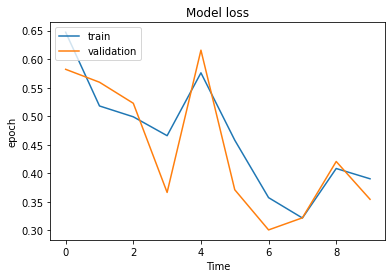

In [26]:
#summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Time')
plt.ylabel('epoch')
plt.legend(['train','validation'],loc = 'upper left')
plt.show()

In [27]:
_,acc = model.evaluate(x_val_features,y_val)
print("Accuracy:",acc)

10/10 [==============================] - 1s 67ms/step - loss: 0.3009 - acc: 0.9136
Accuracy: 0.9136212468147278


**Audio Classification using Time Spectrogram Features**

Let us define a function that computes the spectrogram. Before that, we need to understand how the spectrogram is computed.

**Spectrogram computed**

Spectrogram accepts the raw audio wave and then breaks it into chunks or windows and then applies fast Fourier transformation(FFT) on each window to compute the frequencies.

Coming to the parameters for computing spectrogram:

**nperseg** is the Size of the window i.e. no. of samples in each chunk

**noverlap** is No. of overlapping samples between each window

In this section we will use the signal module from scipy, to compute a spectrogram for a given audio chunk.

This function scipy. **signal.spectrogram** returns three arrays. The first array is the array frequencies and the second array of segment times. These two arrays are not of much use for us as of now, but this third array ‘spec’ is important to us. This represents the spectrogram.

In [28]:
def log_specgram(audio, sample_rate, eps=1e-10):
   nperseg  = 320
   noverlap = 160
   freqs, times, spec = signal.spectrogram(audio,fs=sample_rate,
                           nperseg=nperseg,noverlap=noverlap,detrend=False)
   return freqs, times, np.log(spec.T.astype(np.float32) + eps)

**Visualizing the Spectrogram**

In [29]:
def plot(spectrogram,label):
 fig = plt.figure(figsize=(14, 8))
 ax = fig.add_subplot(211)
 ax.imshow(spectrogram.T, aspect='auto', origin='lower',extent=[times.min(),
                                 times.max(), freqs.min(), freqs.max()])
 ax.set_title('Spectrogram of '+label)
 ax.set_ylabel('Freqs in Hz')
 ax.set_xlabel('Seconds')

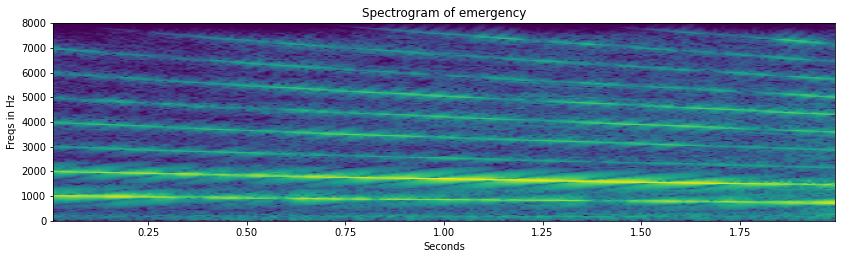

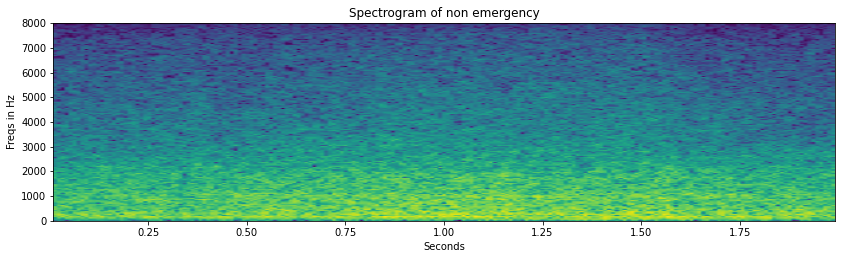

In [30]:
freqs, times, spectrogram = log_specgram(emergency[300], sample_rate)
plot(spectrogram,"emergency")
freqs, times, spectrogram = log_specgram(non_emergency[300], sample_rate)
plot(spectrogram,"non emergency")

In [31]:
spectrogram.shape

(199, 161)

**Extract the spectrogram features**

In [43]:
def extract_spectrogram_features(x_tr):
 features=[]
 for i in x_tr:
   _, _, spectrogram = log_specgram(i, sample_rate)
   mean = np.mean(spectrogram, axis=0)
   std = np.std(spectrogram, axis=0)
   spectrogram = (spectrogram - mean) / std
   features.append(spectrogram)
 return np.array(features)

In [44]:
x_tr_features  = extract_spectrogram_features(x_tr)
x_val_features = extract_spectrogram_features(x_val)

**Model Building using LSTM**

In [47]:
model.mc = lstm(x_tr_features)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 199, 161)]        0         
                                                                 
 lstm (LSTM)                 (None, 128)               148480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
 model (Functional)          (None, 1)                 156801    
                                                                 
Total params: 313,602
Trainable params: 313,602
Non-trainable

In [48]:
history=model.fit(x_tr_features, y_tr, epochs=10,   batch_size=32, validation_data=(x_val_features,y_val))

Epoch 1/10
85/85 [==============================] - 23s 251ms/step - loss: 0.6402 - acc: 0.6268 - val_loss: 0.5577 - val_acc: 0.7309
Epoch 2/10
85/85 [==============================] - 20s 240ms/step - loss: 0.4265 - acc: 0.8267 - val_loss: 0.3612 - val_acc: 0.8439
Epoch 3/10
85/85 [==============================] - 22s 261ms/step - loss: 0.2839 - acc: 0.8856 - val_loss: 0.2240 - val_acc: 0.9336
Epoch 4/10
85/85 [==============================] - 20s 239ms/step - loss: 0.3121 - acc: 0.8834 - val_loss: 0.2703 - val_acc: 0.9169
Epoch 5/10
85/85 [==============================] - 21s 250ms/step - loss: 0.2393 - acc: 0.9152 - val_loss: 0.2615 - val_acc: 0.9136
Epoch 6/10
85/85 [==============================] - 20s 240ms/step - loss: 0.1740 - acc: 0.9352 - val_loss: 0.1726 - val_acc: 0.9468
Epoch 7/10
85/85 [==============================] - 21s 245ms/step - loss: 0.1553 - acc: 0.9404 - val_loss: 0.1639 - val_acc: 0.9369
Epoch 8/10
85/85 [==============================] - 20s 240ms/step - 

In [53]:
_,acc = model.evaluate(x_val_features,y_val)
print("Accuracy:",acc)

10/10 [==============================] - 1s 126ms/step - loss: 0.1575 - acc: 0.9402
Accuracy: 0.9401993155479431
